In [1]:
from pymongo import MongoClient
import pandas as pd

MONGO_URI = "mongodb://localhost:27017/"
DB_NAME   = "News"
COLL_NAME = "rawData"     
LABEL_COL = "state"      

client = MongoClient(MONGO_URI)
coll = client[DB_NAME][COLL_NAME]

# Ignoro "Unnamed: 0" direttamente in projection
FIELDS = {
    "_id": 0, "title": 1, "text": 1, "clean": 1,
    "tokens": 1, "lemmas": 1, LABEL_COL: 1
}
docs = list(coll.find({}, FIELDS))
df = pd.DataFrame(docs)

# Filtri minimi
df = df.dropna(subset=[LABEL_COL]).copy()
df[LABEL_COL] = df[LABEL_COL].astype(str)
print(df.shape)
df.head(2)

(44898, 6)


,title,text,state,clean,tokens,lemmas
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,1,donald trump just couldn t wish all americans ...,"[donald, trump, wish, americans, happy, new, y...","[donald, trump, wish, american, happy, new, ye..."
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,1,house intelligence committee chairman devin nu...,"[house, intelligence, committee, chairman, dev...","[house, intelligence, committee, chairman, dev..."


In [2]:
SEED = 42

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
#import joblib

plt.rcParams["figure.dpi"] = 110


In [3]:
# Assicura che la colonna state sia intera (0/1)
df["state"] = df["state"].astype(int)

X = df["clean"].astype(str)
y = df["state"] 

In [4]:
X = df["clean"]
y = df["state"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Distribuzione y_train (%):\n", (y_train.value_counts(normalize=True)*100).round(1))
print("y_train unique values:", sorted(pd.Series(y_train).unique()))
print("y_test  unique values:", sorted(pd.Series(y_test).unique()))

Train: (35918,) Test: (8980,)
Distribuzione y_train (%):
 state
1    52.3
0    47.7
Name: proportion, dtype: float64
y_train unique values: [np.int64(0), np.int64(1)]
y_test  unique values: [np.int64(0), np.int64(1)]


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    max_df=0.9,
    min_df=5,             # alza un po’ il filtro sui rari
    max_features=100_000, # limita il vocabolario per contenere memoria/tempo
    dtype=np.float32      # dimezza la memoria vs float64
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

X_train_tfidf.shape, X_test_tfidf.shape


((35918, 100000), (8980, 100000))

In [6]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

SVD_COMPONENTS = 300  # puoi provare 200/300/500

svd = TruncatedSVD(n_components=SVD_COMPONENTS, random_state=SEED)
X_train_svd = svd.fit_transform(X_train_tfidf)  # denso ma compatto
X_test_svd  = svd.transform(X_test_tfidf)

# (opzionale ma utile per KNN/GaussianNB/Tree)
scaler = StandardScaler()
X_train_dense = scaler.fit_transform(X_train_svd)
X_test_dense  = scaler.transform(X_test_svd)

X_train_dense.shape, X_test_dense.shape


((35918, 300), (8980, 300))

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

models = {
    "LogReg": LogisticRegression(max_iter=2000, random_state=SEED, class_weight="balanced"),
    "LinearSVM": LinearSVC(random_state=SEED, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=SEED),
    "GaussianNB": GaussianNB(),
    "DecisionTree": DecisionTreeClassifier(random_state=SEED),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

SPARSE_OK = {"LogReg", "LinearSVM"}   # questi vanno bene sul TF-IDF sparso


In [8]:
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix
)
import pandas as pd

results, reports, conf_mats = [], {}, {}

for name, model in models.items():
    print(f"\n=== {name} ===")
    
    if name in SPARSE_OK:
        model.fit(X_train_tfidf, y_train)
        y_pred = model.predict(X_test_tfidf)
    else:
        model.fit(X_train_dense, y_train)   # <-- usa il denso ridotto
        y_pred = model.predict(X_test_dense)
    
    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="binary", zero_division=0
    )
    results.append({"model": name, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1})
    reports[name] = classification_report(y_test, y_pred, digits=3)
    conf_mats[name] = confusion_matrix(y_test, y_pred)

res_df = pd.DataFrame(results).sort_values("f1", ascending=False).reset_index(drop=True)
display(res_df)

for name in res_df["model"]:
    print(f"\n>>> {name} — Classification Report")
    print(reports[name])



=== LogReg ===

=== LinearSVM ===

=== RandomForest ===

=== GaussianNB ===

=== DecisionTree ===

=== KNN ===


,model,accuracy,precision,recall,f1
0,LinearSVM,0.996659,0.995961,0.997658,0.996809
1,LogReg,0.988753,0.991865,0.986584,0.989217
2,RandomForest,0.971826,0.975798,0.970187,0.972985
3,DecisionTree,0.946214,0.938580,0.959966,0.949153
4,KNN,0.857906,0.802227,0.966567,0.876763
5,GaussianNB,0.747661,0.727103,0.828365,0.774438



>>> LinearSVM — Classification Report
              precision    recall  f1-score   support

           0      0.997     0.996     0.996      4284
           1      0.996     0.998     0.997      4696

    accuracy                          0.997      8980
   macro avg      0.997     0.997     0.997      8980
weighted avg      0.997     0.997     0.997      8980


>>> LogReg — Classification Report
              precision    recall  f1-score   support

           0      0.985     0.991     0.988      4284
           1      0.992     0.987     0.989      4696

    accuracy                          0.989      8980
   macro avg      0.989     0.989     0.989      8980
weighted avg      0.989     0.989     0.989      8980


>>> RandomForest — Classification Report
              precision    recall  f1-score   support

           0      0.968     0.974     0.971      4284
           1      0.976     0.970     0.973      4696

    accuracy                          0.972      8980
   macro av

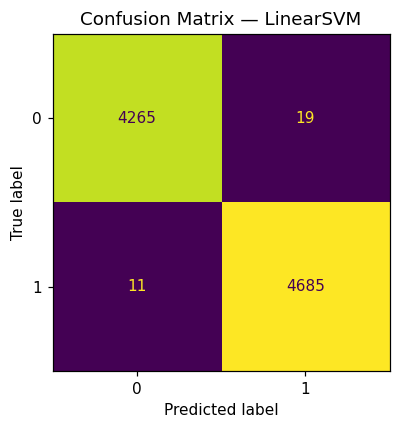

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

best_name = res_df.iloc[0]["model"]
cm = conf_mats[best_name]
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax, colorbar=False)
plt.title(f"Confusion Matrix — {best_name}")
plt.tight_layout(); plt.show()


In [11]:
import numpy as np

print("Train:", X_train_dense.shape, type(X_train_dense))
print("Test :", X_test_dense.shape, type(X_test_dense))

# Se non sono già numpy arrays in float32:
X_train_nn = np.asarray(X_train_dense, dtype=np.float32)
X_test_nn  = np.asarray(X_test_dense, dtype=np.float32)

# Etichette a 1D int
y_train_nn = np.asarray(y_train).astype(int).ravel()
y_test_nn  = np.asarray(y_test).astype(int).ravel()


Train: (35918, 300) <class 'numpy.ndarray'>
Test : (8980, 300) <class 'numpy.ndarray'>


In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

input_dim = X_train_nn.shape[1]  # dovrebbe essere 300

def build_mlp(input_dim, hidden=(256,128), dropout=0.3, l2=1e-4, lr=1e-3):
    inputs = keras.Input(shape=(input_dim,), name="dense_features")
    x = layers.BatchNormalization()(inputs)          # aiuta con feature eterogenee
    x = layers.Dense(hidden[0], activation="relu",
                     kernel_regularizer=keras.regularizers.l2(l2))(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(hidden[1], activation="relu",
                     kernel_regularizer=keras.regularizers.l2(l2))(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid", name="prob_fake")(x)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[keras.metrics.BinaryAccuracy(name="accuracy")]
    )
    return model

model = build_mlp(input_dim= input_dim)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_features (InputLayer)     │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 300)            │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        77,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prob_fake (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,281 (434.69 KB)

 Trainable params: 110,681 (432.35 KB)

 Non-trainable params: 600 (2.34 KB)

In [13]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train_nn)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train_nn)
class_weight = {int(c): float(w) for c, w in zip(classes, class_weights)}
class_weight


{0: 1.04821105468978, 1: 0.956028746340165}

In [14]:
early = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
reduce = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6)


In [15]:
history = model.fit(
    X_train_nn, y_train_nn,
    validation_split=0.1,
    epochs=25,
    batch_size=256,
    callbacks=[early, reduce],
    class_weight=class_weight,   # togli questa riga se le classi sono già bilanciate
    verbose=1
)


Epoch 1/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7439 - loss: 0.5249 - val_accuracy: 0.9822 - val_loss: 0.1026 - learning_rate: 0.0010
Epoch 2/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9744 - loss: 0.1170 - val_accuracy: 0.9861 - val_loss: 0.0865 - learning_rate: 0.0010
Epoch 3/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9863 - loss: 0.0863 - val_accuracy: 0.9855 - val_loss: 0.0833 - learning_rate: 0.0010
Epoch 4/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9906 - loss: 0.0723 - val_accuracy: 0.9872 - val_loss: 0.0795 - learning_rate: 0.0010
Epoch 5/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9909 - loss: 0.0654 - val_accuracy: 0.9905 - val_loss: 0.0730 - learning_rate: 0.0010
Epoch 6/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9947 - loss: 0.0564 - val_accuracy: 0.9875 - val_loss: 0.0777 - learning_rate: 0.0010
Epoch 7/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9951 - loss: 0.0537 - 

281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0     0.9934    0.9897    0.9916      4284
           1     0.9907    0.9940    0.9923      4696

    accuracy                         0.9920      8980
   macro avg     0.9921    0.9919    0.9920      8980
weighted avg     0.9920    0.9920    0.9920      8980

ROC-AUC: 0.999551563243128


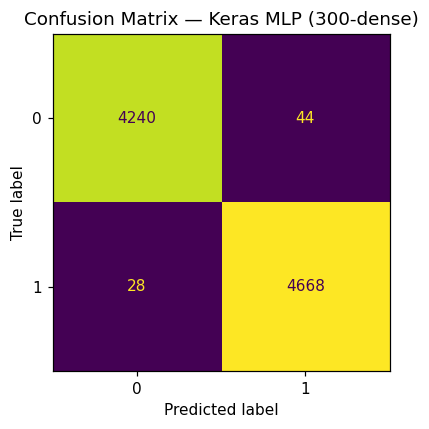

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_proba = model.predict(X_test_nn).ravel()
y_pred  = (y_proba >= 0.5).astype(int)

print(classification_report(y_test_nn, y_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_test_nn, y_proba))

cm = confusion_matrix(y_test_nn, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax, colorbar=False)
plt.title("Confusion Matrix — Keras MLP (300-dense)")
plt.tight_layout(); plt.show()


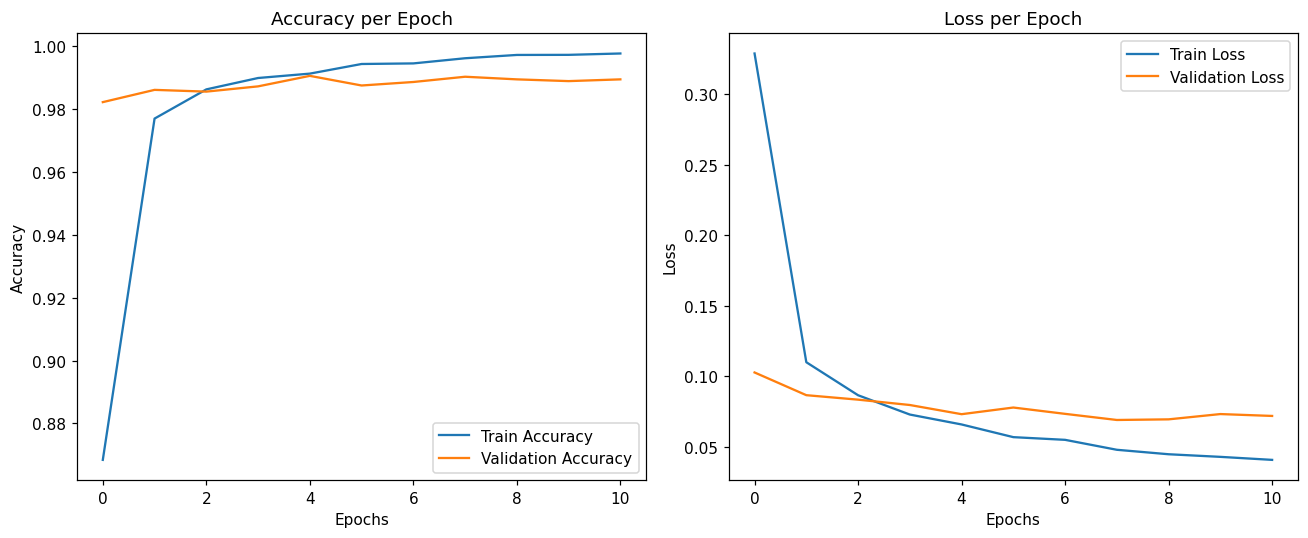

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.tight_layout()
plt.show()


📈 Grafico di sinistra: Accuracy per Epoca

Linea blu (train): parte bassa (~0.87) alla prima epoca, poi cresce molto rapidamente fino a sfiorare 1.00 (accuratezza quasi perfetta).

Linea arancione (validation): parte già alta (~0.98), rimane stabile attorno a 0.985 senza grandi oscillazioni.

👉 Interpretazione:

La rete ha imparato molto in fretta: dopo 2–3 epoche era già oltre il 98% di accuratezza.

La curva di validazione è sempre rimasta molto vicina a quella di training → non vediamo segni evidenti di overfitting.

Il modello sembra stabile e generalizza bene.

📉 Grafico di destra: Loss per Epoca

Linea blu (train): scende velocemente da 0.33 a sotto 0.05 → il modello minimizza bene la loss sul training set.

Linea arancione (validation): parte già bassa (~0.10), scende anch’essa e si stabilizza tra 0.07 e 0.06.

👉 Interpretazione:

La perdita di validazione rimane bassa e non risale → anche qui nessun segnale forte di overfitting.

C’è una piccola differenza tra loss di train (molto bassa) e loss di validazione (leggermente più alta). Questo è normale: significa che il modello si adatta un po’ meglio ai dati che ha visto, ma resta robusto su quelli mai visti.

🎓 Conclusione didattica

Il modello ha una capacità predittiva molto alta (98–99% di accuratezza).

L’allenamento si è stabilizzato presto: probabilmente già entro la 5ª epoca avevamo raggiunto la convergenza.

Non emergono sintomi gravi di overfitting: la generalizzazione sembra ottima.

Se fossimo in un progetto reale, ci porremmo due domande:

I dati di test sono davvero rappresentativi? (accuracy così alta potrebbe significare che il compito è “facile” o che i dati hanno pattern molto chiari).

Ha senso allenare oltre 10 epoche? Probabilmente no, perché non si guadagna nulla.

👉 Da portare a casa per gli studenti:
“Il modello ha imparato velocemente, raggiungendo alta accuratezza senza overfitting. Questo è un caso ideale, ma non sempre succede: spesso vediamo la validation accuracy calare mentre la training accuracy cresce, segnale che dobbiamo regolarizzare meglio o fermarci prima.”

Vuoi che ti prepari anche il commento analogo ma sul grafico ROC/Precision-Recall dopo aver testato il modello, così puoi mostrare ai tuoi compagni un’analisi completa?

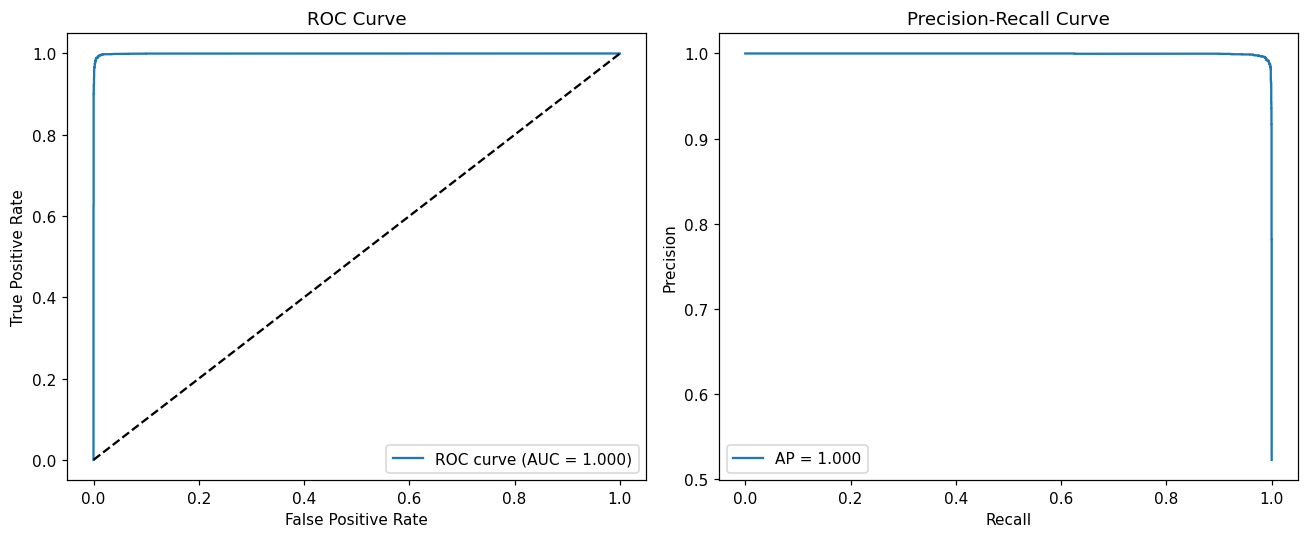

In [18]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Probabilità previste (già calcolate prima)
# y_proba = model.predict(X_test_nn).ravel()

# ROC curve
fpr, tpr, _ = roc_curve(y_test_nn, y_proba)
roc_auc = auc(fpr, tpr)

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test_nn, y_proba)
ap = average_precision_score(y_test_nn, y_proba)

plt.figure(figsize=(12,5))

# --- ROC ---
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1],'k--')  # linea diagonale
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# --- Precision-Recall ---
plt.subplot(1,2,2)
plt.plot(recall, precision, label=f'AP = {ap:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()


📈 Curva ROC (a sinistra)

L’asse x mostra il False Positive Rate (FPR), cioè la proporzione di “non-fake” classificati erroneamente come fake.

L’asse y mostra il True Positive Rate (TPR), cioè la proporzione di fake correttamente identificati.

La linea blu sale subito quasi verticalmente e poi rimane praticamente incollata a 1.0: questo significa che il modello ottiene un TPR altissimo già con un FPR bassissimo.

L’AUC = 1.000 indica che il modello separa perfettamente le due classi nel test set.

👉 Didatticamente: una ROC così è il caso ideale — il modello distingue completamente fake da non-fake.

📉 Curva Precision-Recall (a destra)

L’asse x è il Recall (quante fake news vengono catturate).

L’asse y è la Precision (quante delle notizie etichettate come fake sono davvero fake).

La curva blu resta praticamente piatta a 1.0, con AP (Average Precision) = 1.000: significa che il modello mantiene precisione perfetta qualunque sia il livello di recall.

👉 Didatticamente: non solo il modello non si confonde quasi mai, ma riesce a catturare tutte le fake senza sacrificare la precisione.

🎓 Conclusione didattica

Questi grafici ci mostrano un modello che, sul dataset di test, ha prestazioni perfette o quasi perfette.

Questo è rarissimo nei problemi reali: può voler dire due cose possibili:

I dati hanno caratteristiche molto nette che rendono facile distinguere fake vs non-fake.

Oppure i dati di train e test non sono completamente indipendenti (ad esempio testi simili compaiono in entrambi i set).

👉 Messaggio agli studenti:
“Quando vedete ROC e PR curve perfette, non fermatevi ad esultare. Chiedetevi sempre: il dataset è realistico? È rappresentativo del mondo reale? Potrebbe esserci data leakage? Questi grafici ci dicono che il modello ha imparato bene su questi dati, ma dobbiamo verificare se la stessa perfezione si mantiene su dati nuovi e più complessi.”

In [19]:
import numpy as np
import pandas as pd

# Distribuzione nel train
train_counts = pd.Series(y_train_nn).value_counts().sort_index()
print("Distribuzione TRAIN:")
print(train_counts)

# Distribuzione nel test
test_counts = pd.Series(y_test_nn).value_counts().sort_index()
print("\nDistribuzione TEST:")
print(test_counts)

# Percentuali
print("\nPercentuali TRAIN:")
print((train_counts / train_counts.sum() * 100).round(2))

print("\nPercentuali TEST:")
print((test_counts / test_counts.sum() * 100).round(2))

Distribuzione TRAIN:
0    17133
1    18785
Name: count, dtype: int64

Distribuzione TEST:
0    4284
1    4696
Name: count, dtype: int64

Percentuali TRAIN:
0    47.7
1    52.3
Name: count, dtype: float64

Percentuali TEST:
0    47.71
1    52.29
Name: count, dtype: float64


“Abbiamo verificato che il dataset è ben bilanciato: ~48% notizie vere e ~52% fake, sia nel train che nel test. Questo elimina l’ipotesi che la performance perfetta del modello sia dovuta a uno sbilanciamento delle classi.

Il modello quindi riesce a separare i due tipi di notizie in maniera praticamente perfetta su questo dataset. La domanda didattica che dobbiamo porci è: questo dataset rappresenta davvero la complessità delle fake news nel mondo reale?

Se i testi di train e test sono molto simili (ad esempio copiati da stesse fonti, o con indicatori linguistici troppo evidenti), il rischio è che il modello non stia imparando la ‘natura’ della fake news, ma solo pattern superficiali. Ecco perché il passo successivo sarà testare il modello su dati completamente nuovi o da fonti diverse.”

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test_nn, y_pred)
precision = precision_score(y_test_nn, y_pred)
recall = recall_score(y_test_nn, y_pred)
f1 = f1_score(y_test_nn, y_pred)

print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1       :", f1)


Accuracy : 0.9919821826280624
Precision: 0.9906621392190152
Recall   : 0.9940374787052811
F1       : 0.9923469387755102


In [21]:
nn_results = {
    "model": "NeuralNetwork",
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}


In [ ]:
# Trasforma in DataFrame a una riga
nn_df = pd.DataFrame([nn_results])

# Concatena
results_df = pd.concat([res_df, nn_df], ignore_index=True)

# Visualizza
print(results_df)


           model  accuracy  precision    recall        f1
0      LinearSVM  0.996659   0.995961  0.997658  0.996809
1         LogReg  0.988753   0.991865  0.986584  0.989217
2   RandomForest  0.971826   0.975798  0.970187  0.972985
3   DecisionTree  0.946214   0.938580  0.959966  0.949153
4            KNN  0.857906   0.802227  0.966567  0.876763
5     GaussianNB  0.747661   0.727103  0.828365  0.774438
6  NeuralNetwork  0.991982   0.990662  0.994037  0.992347
